# BiciMAD: Analisis de alquiler de bicis en Madrid - Septiembre 2018

# Modelo predictivo

### El objetivo es entrenar un modelo predictivo para predecir la cantidad de trayectos en bici realizados a nivel de dia y hora, usando las variables que se consideren adecuadas.


#### 1.- Carga de datos

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta

In [3]:
bike_data_path = 'data/bike_data.csv'

In [4]:
rides = pd.read_csv(bike_data_path)

In [5]:
rides.head()

,id,user_day_code,idplug_base,idunplug_base,idplug_station,idunplug_station,user_type,travel_time,ageRange,unplug_hourTime,zip_code
0,5b9058462f38434ab0d85cd3,ead1db07fa526e19fe237115d5516fbdc5acb99057b885...,5,17,16,40,1,263,0,2018-09-01T01:00:00.000+0200,NaN
1,5b9058462f38434ab0d85ce9,420d9e220bd8816681162e15e9afcb1c69c5a756090728...,12,26,52,85,1,382,2,2018-09-01T01:00:00.000+0200,28009
2,5b9058462f38434ab0d85ced,780f5c8157efe8e6dca44dbd689817d4b126364fca917f...,1,11,58,109,1,305,4,2018-09-01T01:00:00.000+0200,28004
3,5b9058462f38434ab0d85cee,a225ab7b4b74954cd9fbe8cc2ec63390cd04e92cdd1a2f...,1,1,120,168,1,262,4,2018-09-01T01:00:00.000+0200,28015
4,5b9058462f38434ab0d85cef,867f38545733bc5f0c69d2592d228e01b3a39daa143e8b...,19,8,80,89,1,310,4,2018-09-01T01:00:00.000+0200,28007


In [6]:
rides['unplug_hourTime'].describe()


count                           398040
unique                             656
top       2018-09-19T19:00:00.000+0200
freq                              1519
Name: unplug_hourTime, dtype: object

In [7]:
len(rides)

398040

#### 2.- Preparación y limpieza de los datos

En primer lugar eliminamos aquellos viajes realizados por trabajadores de la empresa o no sepamos quien los ha realizado.

In [8]:
rides_client = rides[ (rides['user_type'] == 1) | (rides['user_type']==2)]

In [9]:
len(rides_client)

372766

Necesitamos crear un modelo que nos permita predecir el número de viajes diarios en función de la hora y el día, por tanto vamos a tratar de usar **variables relacionadas con esa hora y ese día concreto**. No nos valen las estaciones o la base, o el tiempo de cada trayecto, ya que son variables con las que no contamos en el momento de ejecución del modelo. 
La variable a predecir es el **número de viajes total**, por tanto deberemos seleccionar esta ( o incluso otras segmentaciones como **número de viajes realizados en función del tipo de usuario en esa hora concreta** ) que nos permitan entrenar un modelo con esta/s variables objetivo.

In [10]:
rides_client.loc[:,'date'] = pd.to_datetime(rides_client.loc[:,'unplug_hourTime'])
rides_client.loc[:,'date'] = rides_client.loc[:,'date'].dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid')
rides_client.loc[:,'day'] = (rides_client.loc[:,'date'] + timedelta(hours=24) ).dt.date 
rides_client.loc[:,'hour'] = rides_client.loc[:,'date'].dt.hour
rides_client.loc[:,'day_of_week'] = rides_client.loc[:,'date'].dt.day_name()


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
rides_client.head()

,id,user_day_code,idplug_base,idunplug_base,idplug_station,idunplug_station,user_type,travel_time,ageRange,unplug_hourTime,zip_code,date,day,hour,day_of_week
0,5b9058462f38434ab0d85cd3,ead1db07fa526e19fe237115d5516fbdc5acb99057b885...,5,17,16,40,1,263,0,2018-09-01T01:00:00.000+0200,NaN,2018-09-01 01:00:00+02:00,2018-09-01,1,Saturday
1,5b9058462f38434ab0d85ce9,420d9e220bd8816681162e15e9afcb1c69c5a756090728...,12,26,52,85,1,382,2,2018-09-01T01:00:00.000+0200,28009,2018-09-01 01:00:00+02:00,2018-09-01,1,Saturday
2,5b9058462f38434ab0d85ced,780f5c8157efe8e6dca44dbd689817d4b126364fca917f...,1,11,58,109,1,305,4,2018-09-01T01:00:00.000+0200,28004,2018-09-01 01:00:00+02:00,2018-09-01,1,Saturday
3,5b9058462f38434ab0d85cee,a225ab7b4b74954cd9fbe8cc2ec63390cd04e92cdd1a2f...,1,1,120,168,1,262,4,2018-09-01T01:00:00.000+0200,28015,2018-09-01 01:00:00+02:00,2018-09-01,1,Saturday
4,5b9058462f38434ab0d85cef,867f38545733bc5f0c69d2592d228e01b3a39daa143e8b...,19,8,80,89,1,310,4,2018-09-01T01:00:00.000+0200,28007,2018-09-01 01:00:00+02:00,2018-09-01,1,Saturday


In [12]:
rides_dataset = rides_client.groupby(['date', 'day', 'hour', 'day_of_week']).apply(lambda x: pd.Series(dict(
    registered=(x.user_type == 1).sum(),
    casual=(x.user_type == 2).sum(),
    total=(x.unplug_hourTime).count()
))).reset_index()

In [13]:
rides_dataset.head()

,date,day,hour,day_of_week,registered,casual,total
0,2018-09-01 01:00:00+02:00,2018-09-01,1,Saturday,474,17,491
1,2018-09-01 02:00:00+02:00,2018-09-01,2,Saturday,369,3,372
2,2018-09-01 03:00:00+02:00,2018-09-01,3,Saturday,290,2,292
3,2018-09-01 04:00:00+02:00,2018-09-01,4,Saturday,208,2,210
4,2018-09-01 05:00:00+02:00,2018-09-01,5,Saturday,152,1,153


Veamos una previsualización de los datos de viajes de los 10 primeros días

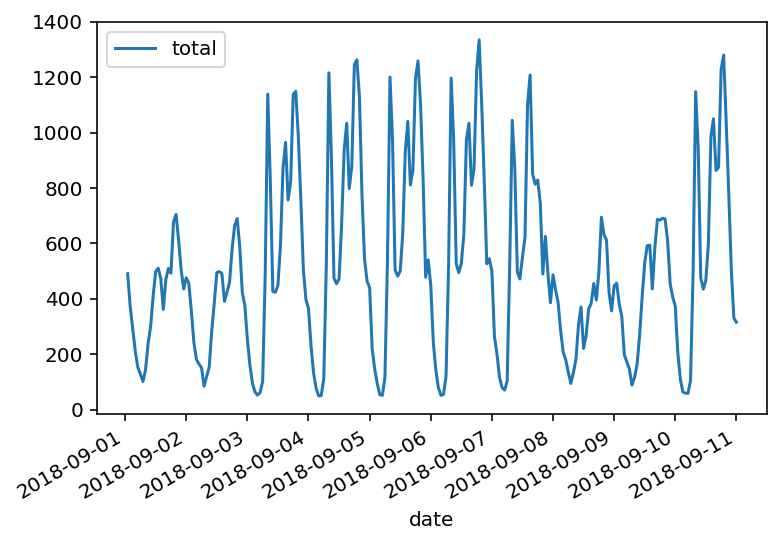

In [14]:
rides_dataset[:24*10].plot(x='date', y='total')

Ya podemos apreciar como disminuye el número de viajes durante los 2 días del fin de semana.
Simplemente con el factor día y hora se aprecia un patrón de número de viajes bastante claro, por lo cual podremos obtener un modelo bastante preciso; sin embargo si añadimos algunas variables que pudiesen influir en el número de viajes conseguiremos aumentar la precisión de nuestro modelo.

#### 3.- Ampliación del dataset con datos meteorológicos

Estos datos pueden ser datos meteorologicos, como temperatura, lluvia o velocidad del viento.
Necesitamos datos horarios del mes de Septiembre en Madrid de esta variables. Hasta hace poco existia una web de referencia en datos meteorologicos que era la del gobierno de EEUU: NOOA, que tenia una API donde recoger todos los datos de todas las estaciones meteorologicas a nivel mundial...y lo más importante: sin coste!!
Esta web no funciona a día de hoy por lo que he obtenido estos datos a través de la API de AEMET...si bien es cierto que solo dan datos a nivel díario ( al menos gratuitamente )
Los datos de temperatura y cantidad de precipitacion se pueden obtener a nivel horario de la web http://www.meteovine.es, sin embargo para los datos de velocidad de viento, he tenido que duplicar el mismo valor ( dado por aemet ) para todas las horas del mismo día.
Tambien hay que tener en cuenta que hay varias estaciones meteorologicas en Madrid que recogen información, y las más proximas al ambito de actuación de biciMAD son Retiro y Ciudad Universitaria, las cuales dan valores un poco diferentes en cuanto a temperatura ( asumimos la diferencia ), pero en cuanto a precipitación habia casos en los que en el Retiro se habian recogido 5.1mm y en Ciudad Universitaria solamente 0.5mm. De cara a modelar he creado una variable sintetica que es un booleano, en el caso de que haya habido precipitaciónes ya que es dificil establecer la cantidad y depende de la ubicación geografica.
Cargamos el fichero de datos climatologicos, ya editado y modificado:

In [15]:
meteo_data_path = 'data/clima_aemet.csv'

In [16]:
meteo = pd.read_csv(meteo_data_path)

In [17]:
meteo.head()

,day,hour,temperature,rain_mm3,rain,windspeed
0,2018-09-01,0,26.6,0.0,0,0.95
1,2018-09-01,1,25.2,0.0,0,0.95
2,2018-09-01,2,24.3,0.0,0,0.95
3,2018-09-01,3,22.9,0.0,0,0.95
4,2018-09-01,4,22.6,0.0,0,0.95


In [18]:
meteo.dtypes

day             object
hour             int64
temperature    float64
rain_mm3       float64
rain             int64
windspeed      float64
dtype: object

Convertimos el campo 'day' a fecha para poder cruzarlo con el DataFrame de viajes

In [19]:
meteo['day'] = pd.to_datetime(meteo['day'], format='%Y-%m-%d')


Unificamos los dos dataset.

In [20]:
complete_dataset = rides_dataset.set_index(['day','hour']).join(meteo.set_index(['day','hour'])).reset_index()

In [21]:
complete_dataset.head()

,day,hour,date,day_of_week,registered,casual,total,temperature,rain_mm3,rain,windspeed
0,2018-09-01,1,2018-09-01 01:00:00+02:00,Saturday,474,17,491,25.2,0.0,0.0,0.95
1,2018-09-01,2,2018-09-01 02:00:00+02:00,Saturday,369,3,372,24.3,0.0,0.0,0.95
2,2018-09-01,3,2018-09-01 03:00:00+02:00,Saturday,290,2,292,22.9,0.0,0.0,0.95
3,2018-09-01,4,2018-09-01 04:00:00+02:00,Saturday,208,2,210,22.6,0.0,0.0,0.95
4,2018-09-01,5,2018-09-01 05:00:00+02:00,Saturday,152,1,153,21.9,0.0,0.0,0.95


#### 4.- Transformación de variables categoricas

Vamos a convertir todas aquellas variables que sean categoricas en tantas variables binarias ( 0 o 1 ) como categorias tiene cada variable.
Para eso utilizaremos la función de get_dummies() de pandas, añadiremos estas variables al dataset y borraremos las que ya hayamos convertido y las que no nos sirvan. En este caso la hora y el día de la semana.
Eliminamos tambien la variable 'rain_mm3' que nos dice la cantidad de precipitación, ya que tenemos la variable 'rain' que nos dice si ha llovido o no.

In [22]:
dummy_variable = ['hour', 'day_of_week']
for variable in dummy_variable:
    dummies = pd.get_dummies(complete_dataset[variable], prefix=variable, drop_first=False)
    complete_dataset = pd.concat([complete_dataset, dummies], axis=1)

fields_to_drop = ['day', 'hour', 'date', 'day_of_week','rain_mm3']
dataset = complete_dataset.drop(fields_to_drop, axis=1)
dataset.head()

,registered,casual,total,temperature,rain,windspeed,hour_0,hour_1,hour_2,hour_3,...,hour_21,hour_22,hour_23,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,474,17,491,25.2,0.0,0.95,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,369,3,372,24.3,0.0,0.95,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,290,2,292,22.9,0.0,0.95,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,208,2,210,22.6,0.0,0.95,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,152,1,153,21.9,0.0,0.95,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 5.- Normalización de variables continuas.

Vamos a normalizar las variables continuas ( transformar las variables para que tengan media 0 y desviación típica 1 ) para facilitar el proceso de entrenamiento: lo haremos menos complejo computacionalmente.
Guardamos los valores de transformación de cada variable para poder hacer la transformación inversa posteriormente.

In [23]:
numeric_variable = ['registered', 'casual', 'total', 'temperature', 'windspeed']

scaled_variable_values = {}
for variable in numeric_variable:
    mean, std = dataset[variable].mean(), dataset[variable].std()
    scaled_variable_values[variable] = [mean, std]
    dataset.loc[:, variable] = (dataset[variable] - mean)/std

In [24]:
dataset.head()

,registered,casual,total,temperature,rain,windspeed,hour_0,hour_1,hour_2,hour_3,...,hour_21,hour_22,hour_23,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,-0.235624,0.892352,-0.210810,0.325290,0.0,-0.655553,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-0.524565,-0.597713,-0.535591,0.147982,0.0,-0.655553,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.741958,-0.704146,-0.753931,-0.127830,0.0,-0.655553,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,-0.967607,-0.704146,-0.977729,-0.186933,0.0,-0.655553,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-1.121709,-0.810580,-1.133296,-0.324839,0.0,-0.655553,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 6.- División en conjunto de datos de entrenamiento y test.

Necesitamos dividir nuestro dataset en dos juegos de datos:
- Uno de entrenamiento con el cual crear el modelo: En problemas tradicionales de ML suele ser el 80% de los datos, aunque en caso de tener muchisimos datos, cuando entrenamos con Redes Neuronales, no se necesita un 20% para test y se puede utilizar mucho más para entrenamiento
- Otro para test, sobre el que se ejecutara el modelo para ver la precisión que tiene sobre este subconjunto

Dado que nuestros datos deben estar balanceados ( es decir, debemos tener la misma proporción de los distintos tipos de datos en ambos subconjuntos: No nos serviria poner todos los datos entre semana en el conjunto de entrenamiento y todos los datos de fin de semana en el de test, ya que el modelo tendria una precisión muy baja ).
Así pues vamos a coger la ultima semana de datos como test y el resto como train. ( aunque esto implique demasiados datos para test - para mi gusto - y ya teniendo de por si muy pocos datos para un problema de predicción.  

In [25]:
# Cogemos como test los ultimos 7 días 
test_data = dataset[-7*24:]

# Eliminamos del dataset los que hemos seleccionado como test 
dataset = dataset[:-7*24]

Marcaremos ahora nuestras variables a predecir, que serán el total de viajes realizados: 'total', los viajes realizados por abonados: 'registered', y los realizados por usuarios casuales o temporales: 'casual'. Y dividiremos nuestros datasets de entrenamiento y test en 'features' y 'target'  

In [26]:
target_fields = ['total', 'casual', 'registered']
features, targets = dataset.drop(target_fields, axis=1), dataset[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

De los datos que nos quedan de entrenamiento vamos a seleccionar otra semana para validar los hiperparametros de nuestra red neuronal: es lo que se llama conjunto de validación y suele ser de un 20%, pero como antes, para que esten balanceados, cogeremos una semana entera.

In [27]:
train_features, train_targets = features[:-7*24], targets[:-7*24]
val_features, val_targets = features[-7*24:], targets[-7*24:]

### Modelos Predictivos

#### 7.1- Red neuronal.

Vamos a entrenar un modelo con una red neuronal con una capa oculta. Para ello debemos definir el numero de nodos inicial, el numero de nodos de la capa oculta, el número de nodos en la capa de salida y la 'tasa' de aprendizaje utilizada en el gradiente de descenso para la optimización de la convergencia.
Ademas utilizaremos como función de activación la función sigmoide, que deberemos implementar y tambien deberemos implementar el 'forward' para el calculo de los pesos de la red neuronal y el 'backpropagation' para la corrección de errores en la función de entrenamiento.

In [28]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initializamos los pesos aleatoriamente
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
                    
    
    def train(self, features, targets):
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            ### Forward pass ###
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) 
            hidden_outputs = self.activation_function(hidden_inputs)

            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
            final_outputs = final_inputs
            
            ### Backward pass ###
            error = y - final_outputs 

            hidden_error = np.dot(error, self.weights_hidden_to_output.T)

            output_error_term = error # Derivada de x = 1
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            delta_weights_i_h += hidden_error_term * X[:, None]
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records
 
    def run(self, features):
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) 
        final_outputs = final_inputs

        return final_outputs

Definimos una función que mida el Error Medio Cuadratico de nuestras prediciones para poder reducirlo cada vez mas.

In [29]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [30]:
#iterations = 8000
#learning_rate = 0.6
#hidden_nodes = 8
#output_nodes = 1

iterations = 16000
learning_rate = 0.4
hidden_nodes = 4
output_nodes = 1

In [31]:
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Entrenamos sobre un conjunto de 128 datos
    batch = np.random.choice(train_features.index, size=6)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['total']
                             
    network.train(X, y)
    
    # Progreso del entrenamiento de la red neuronal
    train_loss = MSE(network.run(train_features).T, train_targets['total'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['total'].values)
    sys.stdout.write("\rProgreso: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progreso: 100.0% ... Training loss: nan ... Validation loss: nan

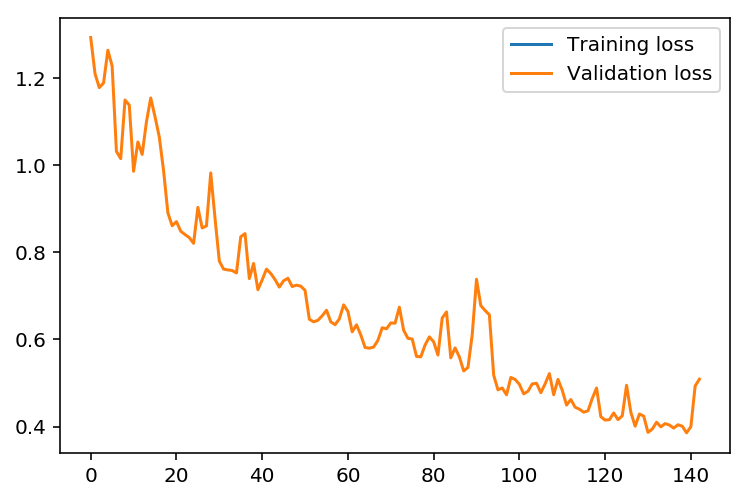

In [32]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

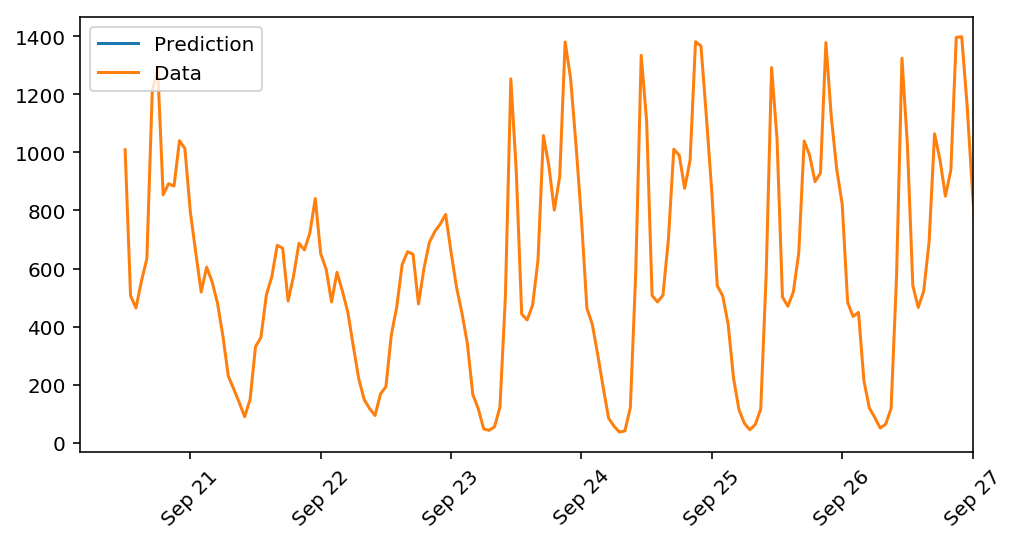

In [55]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_variable_values['total']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['total']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides_dataset.iloc[test_data.index]['day'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

#### 7.2- XGBoost

Vamos a probar ahora un modelo de Boosting para predicción (regresor). XGBoost suele dar muy buen ajuste.

In [34]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
from sklearn.model_selection import GridSearchCV

In [35]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [36]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1) 

In [37]:
gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(features,targets['total'])  
 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, nthreads=-1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f11c94ff9b0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f11c94ff828>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f11c94ffb00>, 'colsample_bytree...4ff438>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f11c94ff438>},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tr

In [38]:
gs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9834353869811083, gamma=1.6376954640722874,
       learning_rate=0.16316647379422716, max_delta_step=0, max_depth=21,
       min_child_weight=2.2968256168124093, missing=None, n_estimators=39,
       n_jobs=1, nthread=None, nthreads=-1, objective='reg:linear',
       random_state=0, reg_alpha=24.120076920631575, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.987210001980065)

In [39]:
model_xgb = xgb.XGBRegressor(max_depth=17, min_child_weight=5, gamma=0.4, colsample_bytree=0.8, subsample=0.8)
model_xgb.fit(features,targets['total'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=17, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

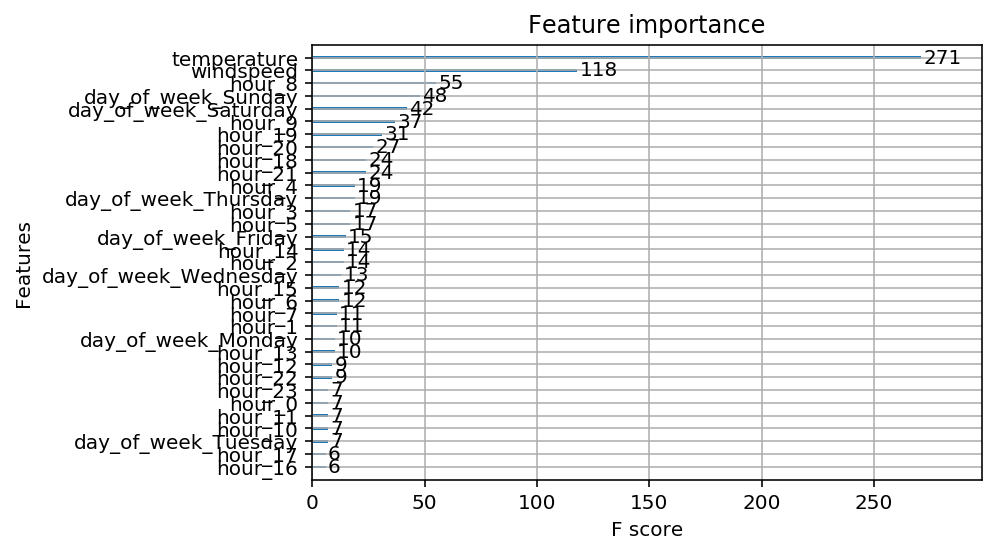

In [40]:
xgb.plot_importance(model_xgb)

In [41]:
xgb_train_pred = model_xgb.predict(features)
xgb_pred = model_xgb.predict(test_features)
print(rmsle(targets['total'], xgb_train_pred))

0.1414382106612434


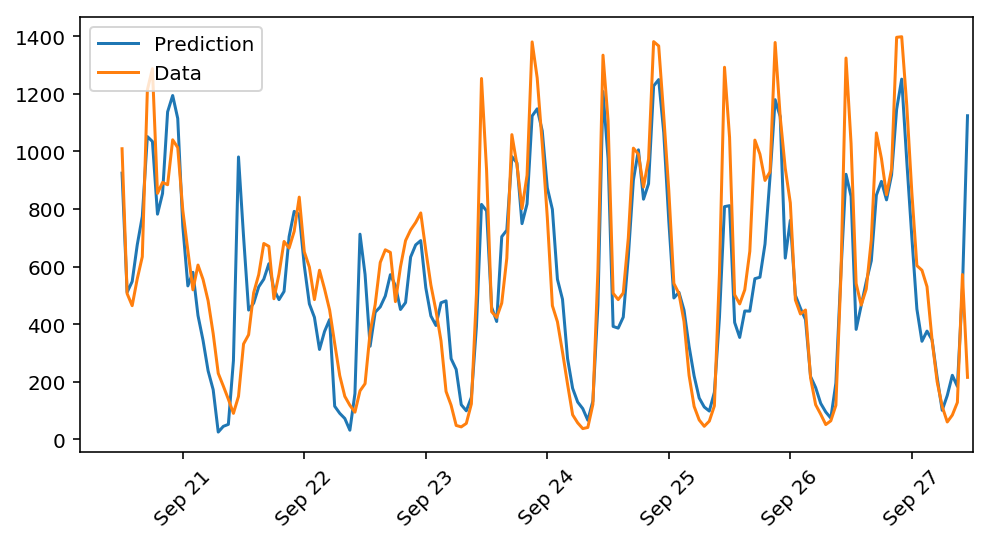

In [53]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_variable_values['total']
predictions = xgb_pred*std + mean
ax.plot(predictions, label='Prediction')
ax.plot((test_targets['total']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides_dataset.iloc[test_data.index]['day'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [ ]:
Vamos que nuestra predicción ajusta bastante bien en el conjunto de test.